In [1]:
# show C-level stderr/stdout
%load_ext lab_black
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path
from nuq import NuqClassifier
import ray
from tqdm.auto import tqdm


ray.init()

2022-02-03 04:13:58,499	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.1.1.27',
 'raylet_ip_address': '10.1.1.27',
 'redis_address': '10.1.1.27:6379',
 'object_store_address': '/tmp/ray/session_2022-02-03_04-13-56_239918_3795811/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-03_04-13-56_239918_3795811/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-02-03_04-13-56_239918_3795811',
 'metrics_export_port': 53710,
 'node_id': '601501635e3a7015e0f655171edda9ee8fa573a3e636c8eb1a5184b6'}

In [3]:
imagenet_emb_train_path = (
    "/gpfs/gpfs0/k.fedyanin/space/imagenet_embeddings/train_embeddings.npy"
)
imagenet_emb_labels_path = (
    "/gpfs/gpfs0/k.fedyanin/space/imagenet_embeddings/train_targets.npy"
)

emb_train = np.load(imagenet_emb_train_path, mmap_mode="c")
labels_train = np.load(imagenet_emb_labels_path, mmap_mode="c")

In [4]:
nuq = NuqClassifier(
    tune_bandwidth="classification:n_points=5;n_folds=10;n_samples=3;verbose=1",
    kernel_type="RBF",
    n_neighbors=20,
    log_pN=0.0,
    verbose=True,
)

nuq.fit(X=emb_train, y=labels_train)

Tuning bandwidth:   0%|          | 0/3 [00:00<?, ?it/s]

  [CLASSIFICATION:N_POINTS=5;N_FOLDS=10;N_SAMPLES=3;VERBOSE=1] bandwidth = 89.48417229846659 (score = 0.69669911096888)


NuqClassifier(tune_bandwidth='classification:n_points=5;n_folds=10;n_samples=3;verbose=1',
              verbose=True)

In [5]:
imagenet_path = "/gpfs/gpfs0/k.fedyanin/space/imagenet_embeddings/val_embeddings.npy"

imagenet_o_path = (
    "/gpfs/gpfs0/k.fedyanin/space/imagenet_embeddings/ood_embeddings_imagenet_o.npy"
)
imagenet_r_path = (
    "/gpfs/gpfs0/k.fedyanin/space/imagenet_embeddings/ood_embeddings_imagenet_r.npy"
)


emb = np.load(imagenet_path, mmap_mode="c")
emb_o = np.load(imagenet_o_path, mmap_mode="c")
emb_r = np.load(imagenet_r_path, mmap_mode="c")

In [9]:
ues_all_path = Path("..", "data", "imagenet", "ues_all.npz")

try:
    ues_all = np.load(ues_all_path)
except FileNotFoundError:
    ues_all = {}
    for name, emb_tmp in tqdm(
        zip(["ues", "ood_ues_o", "ood_ues_r"], [emb, emb_o, emb_r]),
        total=3
    ):
        for method in ["epistemic", "aleatoric", "total"]:
            _, ues_all[name + "_" + method] = nuq.predict_proba(
                emb_tmp, return_uncertainty=method
            )
    np.savez(ues_all_path, **ues_all)

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

OOD ROC AUC 0.643
OOD ROC AUC 0.558
OOD ROC AUC 0.5
OOD ROC AUC 0.417
OOD ROC AUC 0.759
OOD ROC AUC 0.5


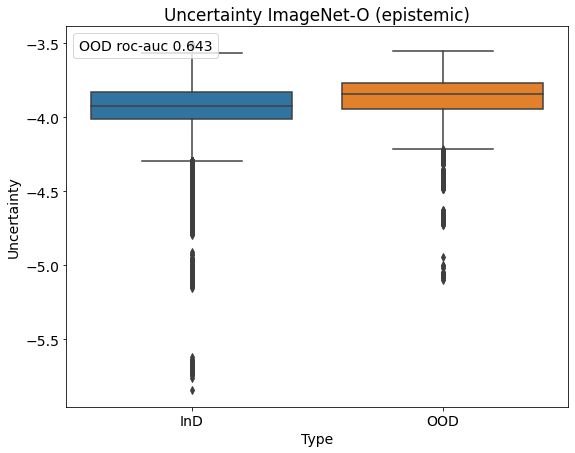

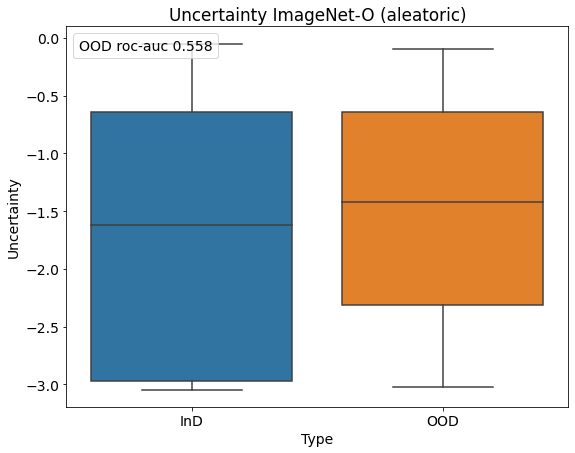

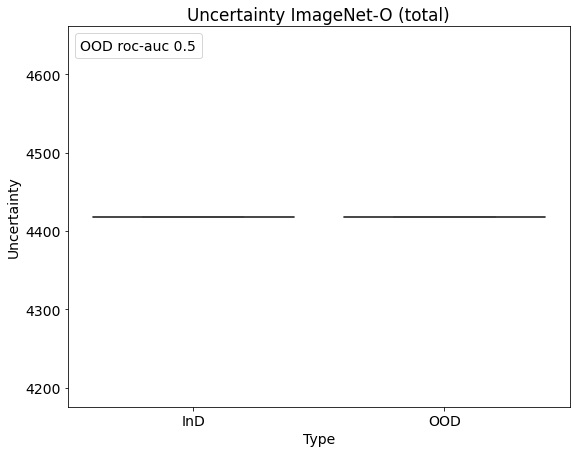

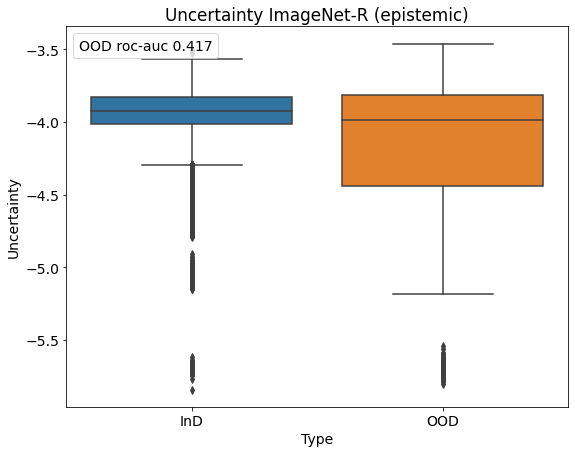

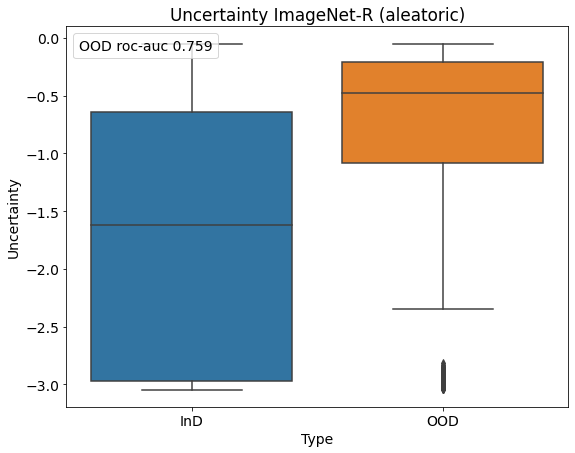

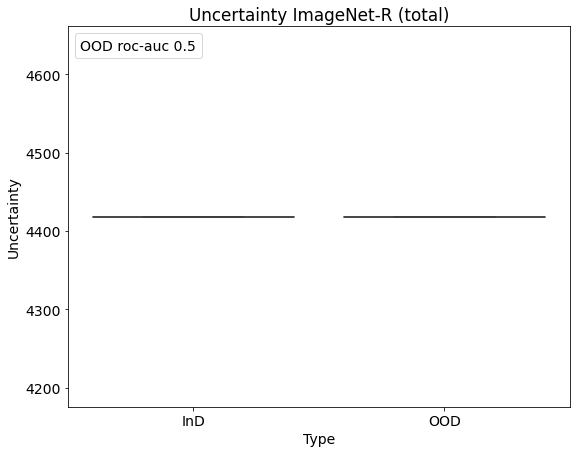

In [11]:
from metrics import uncertainty_plot

for postfix in ["o", "r"]:
    for method in ["epistemic", "aleatoric", "total"]:
        uncertainty_plot(
            ues_all[f"ues_{method}"],
            ues_all[f"ood_ues_{postfix}_{method}"],
            directory="../data",
            file_name=f"imagenet_{postfix}_{method}",
            title=f"Uncertainty ImageNet-{postfix.upper()} ({method})",
        )